### Sandbox for testing code snippets

In [1]:
from importlib.metadata import version


In [2]:
import tiktoken
version('tiktoken')

'0.8.0'

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")

In [4]:
tokenizer

<Encoding 'gpt2'>

In [5]:
tokenizer.encode("Salut je <|endoftext|> m'appelle Jean.", allowed_special={"<|endoftext|>"})

[19221, 315, 11223, 220, 50256, 285, 6, 1324, 13485, 11320, 13]

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('../data/raw/spotify_millsongdata_good.csv')

In [8]:
df.head(10)

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...
5,ABBA,Burning My Bridges,/a/abba/burning+my+bridges_20003011.html,"Well, you hoot and you holler and you make me ..."
6,ABBA,Cassandra,/a/abba/cassandra_20002811.html,Down in the street they're all singing and sho...
7,ABBA,Chiquitita,/a/abba/chiquitita_20002978.html,"Chiquitita, tell me what's wrong \r\nYou're e..."
8,ABBA,Crazy World,/a/abba/crazy+world_20003013.html,I was out with the morning sun \r\nCouldn't s...
9,ABBA,Crying Over You,/a/abba/crying+over+you_20177611.html,I'm waitin' for you baby \r\nI'm sitting all ...


In [9]:
text = "\n<|endoftext|>\n".join(df[df['artist'].str.contains('Kari|Hills|daigle')][['song', 'text']].apply(lambda x: f"Song: {x['song']}\n\n\n{x['text']}" , axis = 1).sample(frac=1, random_state=77).tolist())

with open('../data/raw/kari_hillsong.txt', 'w') as f:
    f.write(text)

In [10]:
len(text)

351745

In [11]:
total_tokens = len(tokenizer.encode(text, allowed_special={'<|endoftext|>'}))
total_tokens

124017

In [12]:
text = text[:5020]
train_ratio = 0.8
train_idx = int(train_ratio * len(text))
train_text = text[:train_idx]
val_text = text[train_idx:]

print(val_text)

 hold the earth in your command  
You are the rock on which I stand  
And as I live each day, I'll follow you  
  
My eyes on all of the above  
My soul secure in all you've done  
My minds made up  
And you are the only one for me  
  
Jesus, savior, in my life you are everything  
My future decided, I will praise your name  
And I know that I am, I am yours  
Yeah, I know that I am, I am yours  
  
Aren't afraid, aren't ashamed Lord we know who we are  
We are your people and we won't be silent  
Unified hear us cry at the top of our lungs  
You our God and we will not be shaken  
  
Aren't afraid, aren't ashamed Lord we know who we are  
We are your people and we won't be silent  
Unified hear us cry at the top of our lungs  
You our God and we will not be shaken  
  
Jesus, savior, in my life you are everything  
My future decided, I will praise your name  
And I know that I am, I am yours  
Yeah, I know that I am, I am yours


<|endoftext|>
Song: Here Now 


# create data loader

In [13]:
from src.datasets.gpt_datasets import create_data_loader_v1
from src.models.loss import calc_loss_batch, calc_loss_loader
from src.models.gpt import GPTModel
from src.generate import text_to_token_ids
from src.train import train_model_simple
import torch

In [14]:
MAX_LENGTH = 128

In [15]:
train_data_loader = create_data_loader_v1(
    train_text,
    batch_size=2,
    max_length=MAX_LENGTH,
    stride=MAX_LENGTH,
    drop_last=True,
    shuffle=True,
    num_workers=0
)

1445


In [16]:
val_data_loader = create_data_loader_v1(
    val_text,
    batch_size=2,
    max_length=MAX_LENGTH,
    stride=MAX_LENGTH,
    drop_last=True,
    shuffle=True,
    num_workers=0
)

337


In [17]:
for x,y in val_data_loader:
    print(x.shape, y.shape)

torch.Size([2, 128]) torch.Size([2, 128])


In [18]:

GPT_CONFIG_124M = {
        "vocab_size": 50257,  # Vocabulary size
        "context_length": 128,  # Context length
        "emb_dim": 768,  # Embedding dimension
        "n_heads": 12,  # Number of attention heads
        "n_layers": 12,  # Number of layers
        "drop_rate": 0.1,  # Dropout rate
        "qkv_bias": False  # Query-Key-Value bias
    }

In [18]:


tokenizer = tiktoken.get_encoding('gpt2')
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (layer_norm1): LayerNorm()
      (multi_head_attention): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=768, bias=False)
        (W_K): Linear(in_features=768, out_features=768, bias=False)
        (W_V): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (layer_norm2): LayerNorm()
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBloc

In [19]:

model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (layer_norm1): LayerNorm()
      (multi_head_attention): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=768, bias=False)
        (W_K): Linear(in_features=768, out_features=768, bias=False)
        (W_V): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (layer_norm2): LayerNorm()
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBloc

In [20]:
with torch.no_grad():
    train_loss = calc_loss_loader(data_loader=train_data_loader, model=model, device=device)
    va_loss = calc_loss_loader(data_loader=val_data_loader, model=model, device=device)
    
print('Training loss: ', train_loss)
print('Validation loss: ', va_loss)

Training loss:  10.890707778930665
Validation loss:  10.882466316223145


### Training

In [20]:
GPT_CONFIG_124M = {
        "vocab_size": 50257,  # Vocabulary size
        "context_length": 128,  # Context length
        "emb_dim": 768,  # Embedding dimension
        "n_heads": 12,  # Number of attention heads
        "n_layers": 12,  # Number of layers
        "drop_rate": 0.1,  # Dropout rate
        "qkv_bias": False  # Query-Key-Value bias
    }
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = tiktoken.get_encoding('gpt2')
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (layer_norm1): LayerNorm()
      (multi_head_attention): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=768, bias=False)
        (W_K): Linear(in_features=768, out_features=768, bias=False)
        (W_V): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (layer_norm2): LayerNorm()
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBloc

In [21]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)

In [22]:
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(model, train_data_loader, val_data_loader, optimizer, device, num_epochs=num_epochs, eval_freq=5, eval_iter=5, start_context="When i see your", tokenizer=tokenizer)

Ep 1 (Step 000000): Train loss 7.067, Val loss 7.970
  en i see your 
Ep 2 (Step 000005): Train loss 5.202, Val loss 6.576
 You are the  ou You are the You are the You are the You are the You are the You are the 
Ep 3 (Step 000010): Train loss 3.939, Val loss 5.924
 And you, you, you,, you, you, you,                   
Ep 4 (Step 000015): Train loss 2.983, Val loss 5.349
      alive f   song 
Ep 5 (Step 000020): Train loss 1.787, Val loss 5.115
      now that,  , g 
Ep 6 (Step 000025): Train loss 1.248, Val loss 4.980
When i see your song that,                                               
Ep 7 (Step 000030): Train loss 0.925, Val loss 5.011
When i see your song that Lord, He's alive                                           
Ep 8 (Step 000035): Train loss 0.652, Val loss 4.922
 And his glory appears like the light from the sun.
Ep 9 (Step 000040): Train loss 0.509, Val loss 5.079
   have found Your peace    have a plan 
Ep 10 (Step 000045): Train loss 0.413, Val loss 4.929
 It replac

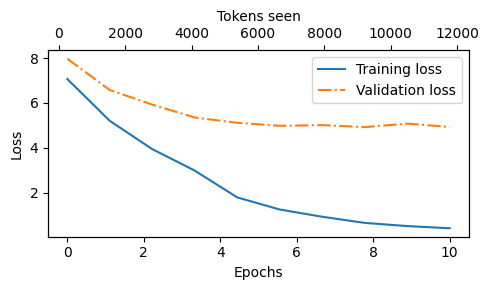

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny() #1
    ax2.plot(tokens_seen, train_losses, alpha=0) #2
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))    
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [25]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (layer_norm1): LayerNorm()
      (multi_head_attention): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=768, bias=False)
        (W_K): Linear(in_features=768, out_features=768, bias=False)
        (W_V): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (layer_norm2): LayerNorm()
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBloc

In [26]:
from src.generate import generate_text, token_ids_to_text

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text(
model=model,
idx=text_to_token_ids("When i see what you", tokenizer),
max_new_tokens=25,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 When i see what you my Lord, 
He's alive, He's alive  
 
And Jesus lives forever 


In [49]:
import tiktoken

In [51]:
tiktoken.get_encoding("gpt2").n_vocab

50257

In [35]:
import torch
torch.manual_seed(77)

In [52]:
vocab_size = tiktoken.get_encoding("gpt2").n_vocab
output_dim = 256

embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [53]:
print(embedding_layer(torch.tensor([[3, 3, 3], [2, 2, 2]])))

tensor([[[ 0.5709, -2.2380,  1.1550,  ..., -0.4621,  0.5677, -0.6434],
         [ 0.5709, -2.2380,  1.1550,  ..., -0.4621,  0.5677, -0.6434],
         [ 0.5709, -2.2380,  1.1550,  ..., -0.4621,  0.5677, -0.6434]],

        [[ 0.2633, -1.0764,  1.3340,  ..., -0.3900,  0.5351, -0.7978],
         [ 0.2633, -1.0764,  1.3340,  ..., -0.3900,  0.5351, -0.7978],
         [ 0.2633, -1.0764,  1.3340,  ..., -0.3900,  0.5351, -0.7978]]],
       grad_fn=<EmbeddingBackward0>)


In [54]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)